# **Import some packages**

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
import pandas as pd
import yfinance as yf
from tqdm import tqdm
from scipy.stats import norm

In [ ]:
underlying = ['0050.TW', '1101.TW', '1216.TW', '2330.TW', '2884.TW', '2603.TW', '00632R.TW']

df = yf.download(underlying, start='2021-06-01', end='2022-06-01')['Adj Close']
df.describe()

[*********************100%***********************]  7 of 7 completed


,0050.TW,00632R.TW,1101.TW,1216.TW,2330.TW,2603.TW,2884.TW
count,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000
mean,137.577143,5.437918,42.250578,65.448116,581.078945,272.691403,25.359716
std,5.726997,0.203077,1.782907,1.743493,30.369601,42.892004,2.629571
min,121.250000,5.030000,36.113262,61.669483,499.394012,180.479736,21.370872
25%,135.050003,5.270000,41.822346,64.455177,566.520142,251.902771,23.053619
50%,138.000000,5.460000,42.397678,65.319710,580.852600,275.170898,25.318756
75%,141.100006,5.590000,43.150036,66.528221,595.335449,290.345764,27.146826
max,152.000000,5.870000,45.761166,69.762238,672.089355,444.586761,32.311119


## 對數收益率

In [ ]:
# 收益 LOG
log_data = np.log(df) - np.log(df.shift(1))
#
log_data.describe()

,0050.TW,00632R.TW,1101.TW,1216.TW,2330.TW,2603.TW,2884.TW
count,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000
mean,-0.000242,-0.000212,-0.000778,-0.000388,-0.000269,0.001078,0.000927
std,0.010591,0.010409,0.010167,0.009344,0.014193,0.044279,0.011057
min,-0.044223,-0.031749,-0.070952,-0.053597,-0.041569,-0.105361,-0.055408
25%,-0.005326,-0.007208,-0.005439,-0.005924,-0.008573,-0.021664,-0.003490
50%,0.000000,0.000000,-0.001006,0.000000,0.000000,0.003497,0.000000
75%,0.005775,0.005487,0.004034,0.005831,0.008320,0.025529,0.005043
max,0.031276,0.030134,0.028820,0.025662,0.046044,0.095310,0.037483


In [ ]:
### Start to derive weight
weight = []
returns = []
risk = []
sharpe = []

num_stock = len(underlying)
num_portfo = 30000
for i in tqdm(range(num_portfo)):
    portfo_weight = np.random.random(num_stock)
    portfo_weight /= np.sum(portfo_weight)
    weight.append(portfo_weight)
    portfo_return = pow(np.dot(portfo_weight, log_data.mean())+1, 244)-1
    portfo_risk = np.sqrt(np.dot( portfo_weight.T, np.dot(log_data.cov()*244, portfo_weight)))
    portfo_sharpe = (portfo_return - 0.01)/portfo_risk
    returns.append(portfo_return)
    risk.append(portfo_risk)
    sharpe.append(portfo_sharpe)

100%|██████████| 30000/30000 [00:49<00:00, 600.28it/s]


In [ ]:
portfolio = {"return":returns,"risk":risk,"sharpe":sharpe}  ###把資料都丟到字典裡
for index,stock in enumerate(underlying):
    portfolio[stock[0:-3]+"-weight"] = [each[index] for each in weight]
### 生出PORTFOLIO DATAFRAME
df_portfolio = pd.DataFrame(portfolio)
df_portfolio.describe()

,return,risk,sharpe,0050-weight,1101-weight,1216-weight,2330-weight,2884-weight,2603-weight,00632R-weight
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,0.004686,0.137580,-0.102793,0.143025,0.142858,0.143223,0.142618,0.142511,0.142908,0.142857
std,0.037324,0.043384,0.329359,0.082074,0.081771,0.081588,0.081641,0.081558,0.081981,0.082152
min,-0.112712,0.026509,-1.943645,0.000010,0.000015,0.000013,0.000003,0.000034,0.000002,0.000015
25%,-0.020510,0.105283,-0.269734,0.076962,0.076611,0.078157,0.076792,0.076470,0.077430,0.076667
50%,0.004034,0.133907,-0.043892,0.142726,0.142452,0.143184,0.142375,0.142571,0.143214,0.142478
75%,0.028679,0.165599,0.120804,0.201302,0.202087,0.201612,0.201119,0.201227,0.201188,0.201136
max,0.231142,0.438099,1.107535,0.557589,0.537684,0.585463,0.618422,0.593409,0.618432,0.607518


In [ ]:
df_best = df_portfolio[df_portfolio["sharpe"].isin([df_portfolio["sharpe"].max()])]

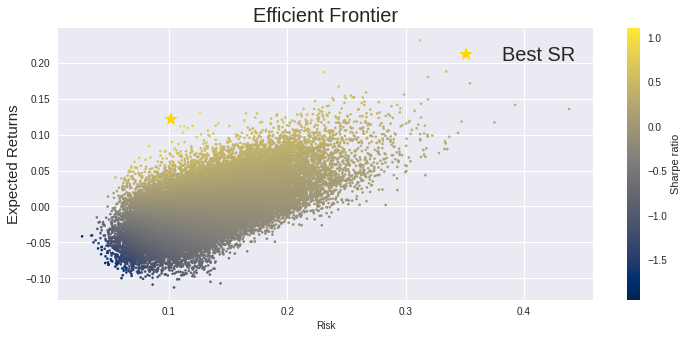

In [ ]:
## 散點圖!!
ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(12, 5)
plt.style.use("seaborn")

plt.scatter(x =df_portfolio["risk"],y =df_portfolio["return"],s = 5,c=df_portfolio["sharpe"],cmap = "cividis")
plt.plot(df_best["risk"], df_best["return"],"w*" ,markersize = 15,label ="Best SR", color = 'gold')

plt.xlabel("Risk", fontsize=10)
plt.ylabel('Expected Returns',fontsize=15)
plt.title('Efficient Frontier',fontsize=20)
plt.colorbar(label='Sharpe ratio')
plt.grid(True)
plt.legend(loc='upper right', fontsize=20)
plt.show()

### 求解SHARPE最優

## 構造有效前緣
### 求解夏普最優(i mean for all the feasible portfolios)

In [ ]:
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy import stats

In [ ]:
#最大夏普率
def indexes(weight,df = log_data):
    portfo_return = pow(np.dot(weight,df.mean())+1,244)-1
    portfo_risk = np.sqrt(np.dot(weight.T, np.dot(df.cov()*252,weight)))
    portfo_sharpe = (portfo_return - 0.01)/portfo_risk
    return np.array([portfo_return, portfo_risk, portfo_sharpe])
def min_sharpe(weight):         ###Object function
    return -indexes(weight,log_data)[2]  ###因為scipy.optimize只有minimize。。。
def min_variance(weight):
    return indexes(weight)[1] ** 2

### scipy求解 非線性規劃
num_stock = len(underlying)
bnds = list((0., 1.) for x in range(num_stock))  ###權重介於0-1之間，有num_stock比權重
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) ### x1+x2+.....+xn = 1
initial_cond = np.array(num_stock * [1. / num_stock])
print("------------------Initial Condition----------------------")
for i,j in enumerate(underlying):
     print(j[0:-3]," = ",initial_cond[i].round(3))
print("---------------------------------------------------------\n\n")
solvs = sco.minimize(min_sharpe , initial_cond, method='SLSQP',  bounds=bnds, constraints=cons)
print(solvs)
print("\n\n------------------Optimal Condition----------------------")
for i,j in enumerate(underlying):
     print(j[0:-4]," = ",solvs['x'].round(3)[i])  #即為最大夏普率的投資组合的權重分配
print(indexes(solvs['x']).round(3))  #獲得最大夏普率的投資组合的收益率、波動率和夏普率
#最小方差的投資组合

------------------Initial Condition----------------------
0050  =  0.143
1101  =  0.143
1216  =  0.143
2330  =  0.143
2884  =  0.143
2603  =  0.143
00632R  =  0.143
---------------------------------------------------------


     fun: -1.4100194411515117
     jac: array([ 1.06578192, -0.22094646,  1.95717441,  1.18687032,  1.04422081,
       -0.21977948, -0.22114295])
 message: 'Optimization terminated successfully'
    nfev: 81
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([0.00000000e+00, 7.54860311e-02, 7.68824533e-17, 8.44399217e-16,
       0.00000000e+00, 4.34535064e-02, 8.81060462e-01])


------------------Optimal Condition----------------------
005  =  0.0
110  =  0.075
121  =  0.0
233  =  0.0
288  =  0.0
260  =  0.043
00632  =  0.881
[0.23  0.156 1.41 ]


### 最小VARIANCE

In [ ]:
def min_variance(weight):
    return indexes(weight)[1] ** 2

### scipy求解 非線性規劃
num_stock = len(underlying)
bnds = list((0., 1.) for x in range(num_stock))  ###權重介於0-1之間，有num_stock比權重
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) ### x1+x2+.....+xn = 1
initial_cond = np.array(num_stock * [1. / num_stock])
print("------------------Initial Condition----------------------")
for i,j in enumerate(underlying):
     print(j[0:-4]," = ",initial_cond[i].round(3))
print("---------------------------------------------------------\n\n")
solvs2 = sco.minimize(min_variance , initial_cond, method='SLSQP',  bounds=bnds, constraints=cons)
print(solvs2)
print("\n\n------------------Optimal Condition----------------------")
for i,j in enumerate(underlying):
     print(j[0:-3]," = ",solvs2['x'].round(3)[i])  #即為最大夏普率的投資组合的權重分配
print(indexes(solvs2['x']).round(3))  #獲得最大夏普率的投資组合的收益率、波動率和夏普率
#最小方差的投資组合

------------------Initial Condition----------------------
005  =  0.143
110  =  0.143
121  =  0.143
233  =  0.143
288  =  0.143
260  =  0.143
00632  =  0.143
---------------------------------------------------------


     fun: 0.0006071996631450409
     jac: array([0.00124276, 0.0011998 , 0.00104984, 0.00121702, 0.00187589,
       0.00114595, 0.00121973])
 message: 'Optimization terminated successfully'
    nfev: 184
     nit: 23
    njev: 23
  status: 0
 success: True
       x: array([4.31683287e-01, 4.85707229e-01, 2.69899792e-02, 1.83255802e-02,
       9.75781955e-19, 1.29625189e-02, 2.43314056e-02])


------------------Optimal Condition----------------------
0050  =  0.432
1101  =  0.486
1216  =  0.027
2330  =  0.018
2884  =  0.0
2603  =  0.013
00632R  =  0.024
[-0.047  0.025 -2.332]


100%|██████████| 50/50 [00:10<00:00,  4.86it/s]


[0.056369046922378284, 0.04755456119896525, 0.039460620702911536, 0.0326091493679795, 0.027812029321880198, 0.02523031042974589, 0.024670636031759542, 0.02475113544339079, 0.02538123432850896, 0.02652456743540091, 0.02830555074654, 0.03067253651797556, 0.033476663769260784, 0.03659324201111263, 0.03993731039437986, 0.04344568244367172, 0.04707263332339177, 0.05078393851371599, 0.05455515829814216, 0.05836756671443645, 0.06220753928389723, 0.06606355607326019, 0.06992869851400707, 0.07379590951370292, 0.07766091952470447, 0.08156656525643294, 0.08553811125100381, 0.08956137310189953, 0.09362487623759519, 0.09771900230806732, 0.10183560026313644, 0.10611176962908245, 0.11068171297122634, 0.11550134612693462, 0.12053196620808213, 0.1257401424022341, 0.13109699946882106, 0.1365779231929821, 0.1421618465257627, 0.14783076895903646, 0.1535694748307104, 0.15936484265569736, 0.16520568957389187, 0.17108248085738817, 0.18537231663648515, 0.25509622934199383, 0.354253208556855, 0.463745980185112

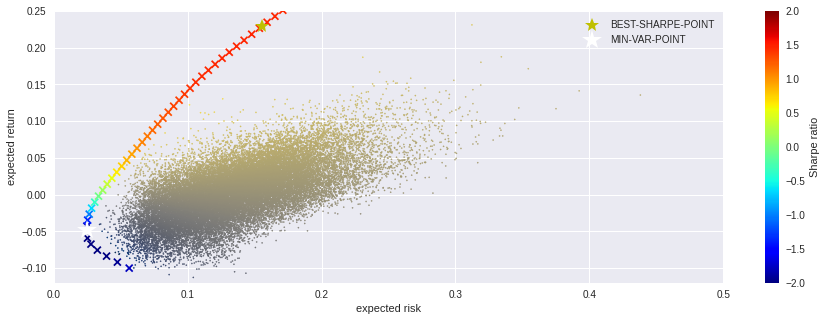

In [ ]:
### plot the frontier
def best_port(weight):
    return indexes(weight)[1]
return_interval = np.linspace(-0.1, 0.3, 50)
corr_risk = []
i = 0
for prt in tqdm(return_interval):
    cons = ({'type': 'eq', 'fun': lambda x:  indexes(x)[0] - prt},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(best_port, initial_cond, method='SLSQP',
                       bounds=bnds, constraints=cons)
    corr_risk.append(indexes(res["x"])[1])
print(corr_risk)
corr_risk = np.array(corr_risk)
ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.scatter(df_portfolio["risk"],df_portfolio["return"],s = 1.5,c = df_portfolio["sharpe"],marker = "o",cmap = 'cividis')

plt.scatter(corr_risk, return_interval,c = (return_interval) / corr_risk, marker='x',cmap = 'jet')
plt.plot(indexes(solvs['x'])[1], indexes(solvs['x'])[0],'y*', markersize=15.0, label = "BEST-SHARPE-POINT")
plt.plot(indexes(solvs2["x"])[1], indexes(solvs2["x"])[0], 'w*', markersize=20.0, label = "MIN-VAR-POINT")
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

plt.xlim(0.0, 0.5)
plt.ylim(-0.12, 0.25)
plt.grid(True)
plt.xlabel('expected risk')
plt.ylabel('expected return')
plt.clim(-2, 2)
plt.colorbar(label='Sharpe ratio')
plt.legend(fontsize=10)